In [1]:
!pip install yfinance
!pip install mplfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd
import requests
from datetime import date
import math


# Define the stock code and the number of days to fetch
#sc, days = 'AAPL', 200

# Fetch the stock data from Yahoo Finance
#end_date = pd.Timestamp.now()
#start_date = end_date - pd.Timedelta(days=days)
#df = yf.download(stock_code, start=start_date, end=end_date)
def get_stonks(sc,days):
  end_date = pd.Timestamp.now()
  start_date = end_date - pd.Timedelta(days=days)
  return yf.download(sc, start=start_date, end=end_date)



In [3]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [4]:
def implement_st_strategy(prices, st):
    buy_price = []
    sell_price = []
    st_signal = []
    signal = 0
    
    for i in range(len(st)):
        if st[i-1] > prices[i-1] and st[i] < prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st[i-1] < prices[i-1] and st[i] > prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                st_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
            
    return buy_price, sell_price, st_signal


In [5]:
def make_supertrend(df,sc):
  df['st'], df['s_upt'], df['st_dt'] = get_supertrend(df['High'], df['Low'], df['Close'], 10, 3)
  df_2 = df[1:]
  df['mean_price'] = df[["High","Low"]].mean(axis = 1)
  #print(df.head())
  plt.plot(df['Close'], linewidth = 2, label = 'CLOSING PRICE')
  plt.plot(df['st'], color = 'green', linewidth = 2, label = 'ST UPTREND 10,3')
  plt.plot(df['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND 10,3')
  plt.legend(loc = 'upper left')
  plt.show()
  buy_price, sell_price, st_signal = implement_st_strategy(df['Close'], df['st'])
  one, two = implement_st_new1(df['Close'],df['st'],df['mean_price'],df.index)
  plt.plot(df['Close'], linewidth = 2)
  plt.plot(df['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
  plt.plot(df['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
  plt.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
  plt.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
  plt.title(sc + ' ST TRADING SIGNALS')
  plt.legend(loc = 'upper left')
  plt.show()
  plt.savefig('graph_st.png')
  print(one)
  print(two)
  #print(three)
  #print(four)
 

In [6]:
import math
import numpy as np

def implement_st_new1(prices, st, mean, dates):
    buy_price = []
    sell_price = []
    st_signal = []
    signal = 0
    buy_extra_list = []
    sell_extra_list = []
    buy_count = 0
    sell_count = 0
    for i in range(len(st)):
        if st[i-1] > prices[i-1] and st[i] < prices[i]:
            if signal != 1:
                onlydate = dates[i].date()
                buy_list = [mean[i], onlydate]
                p = round(prices[i], 2)
                buy_price.append(p)
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
                buy_extra_list.append(buy_list)
                buy_count += 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st[i-1] < prices[i-1] and st[i] > prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                onlydate = dates[i].date()
                buy_list = [mean[i], onlydate]
                sell_list = [mean[i], onlydate]
                p = round(prices[i], 2)
                sell_price.append(p)
                signal = -1
                st_signal.append(signal)
                sell_extra_list.append(sell_list)
                sell_count += 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
    buy_return = [buy_extra_list, buy_count]
    sell_return = [sell_extra_list, sell_count]
    return buy_return, sell_return


In [7]:
def implement_st_new(prices, st,mean,dates):
    buy_price = []
    sell_price = []
    st_signal = []
    signal = 0
    buy_extra_list = []
    sell_extra_list = []
    buy_count = 0
    sell_count = 0
    for i in range(len(st)):
        if st[i-1] > prices[i-1] and st[i] < prices[i]:
            if signal != 1:
                onlydate = dates[i].date()
                buy_list = [mean[i],onlydate]
                p = round(prices[i],2)
                buy_price.append(p)
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
                buy_extra_list.append(buy_list)
                buy_count += 1

            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st[i-1] < prices[i-1] and st[i] > prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                onlydate = dates[i].date()
                buy_list = [mean[i],onlydate]
                sell_list = [mean[i],onlydate]
                p = round(prices[i],2)
                sell_price.append(p)
                signal = -1
                st_signal.append(signal)
                sell_extra_list.append(sell_list)
                sell_count += 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
    buy_return = [buy_extra_list,buy_count]
    sell_return = [sell_extra_list,sell_count]
            
    return buy_return,sell_return


Enter Stock CodeAAPL
Enter days30
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-d88e177abc05>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_bands.iloc[:,1] = final_bands.iloc[:,0]


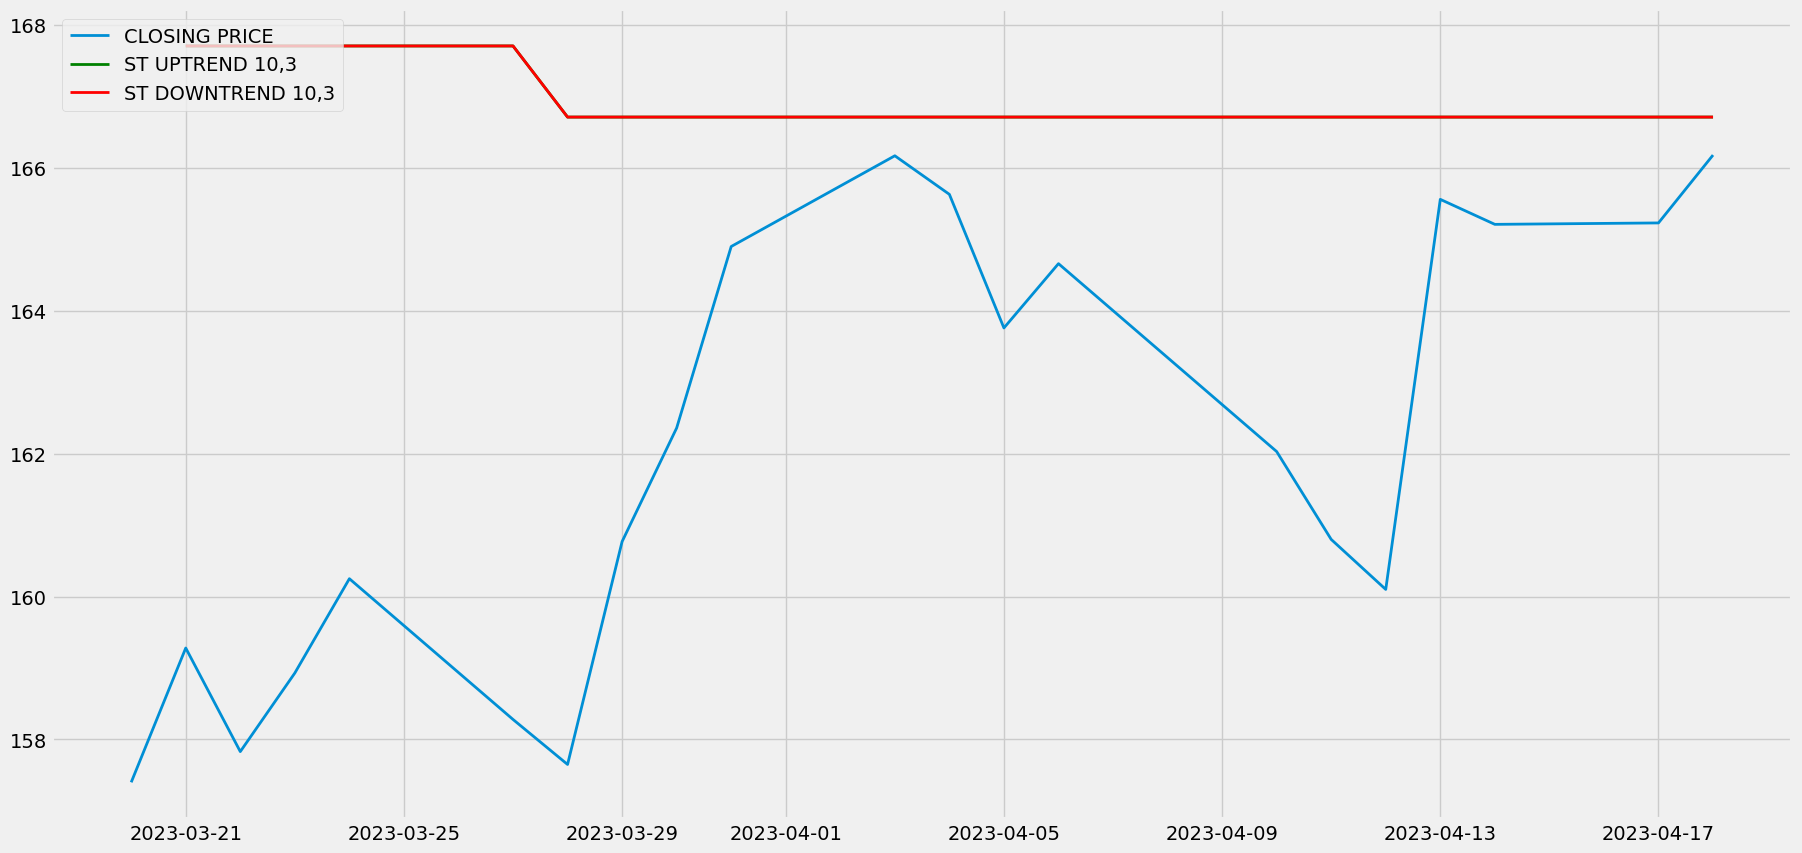

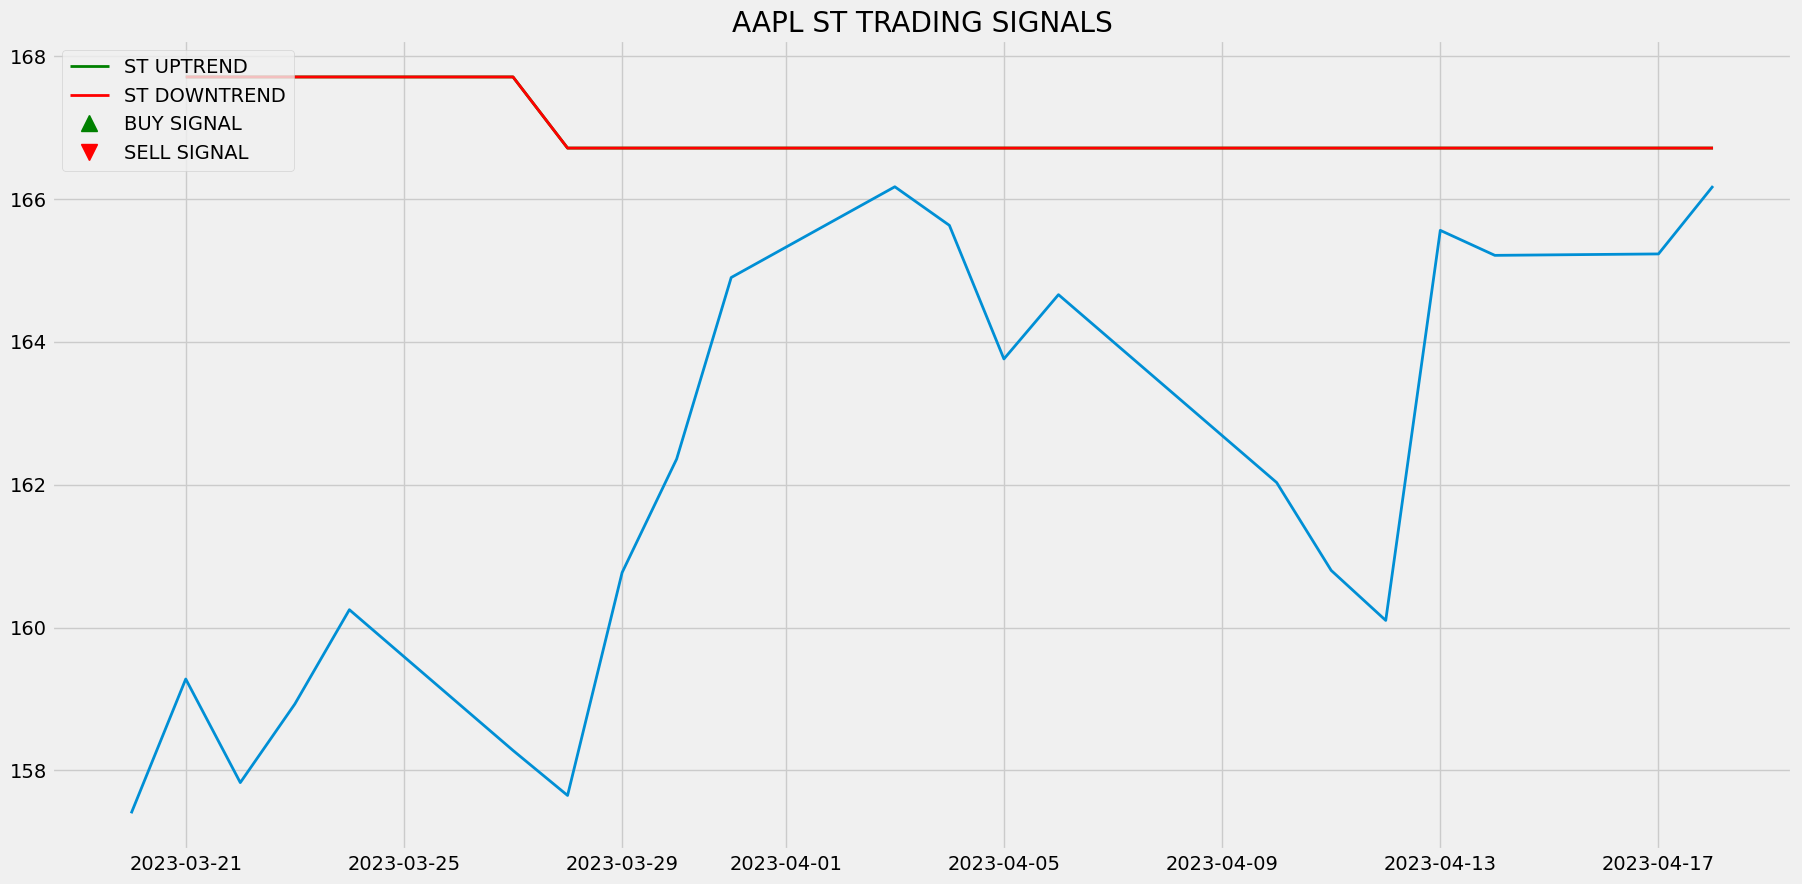

[[], 0]
[[], 0]


<Figure size 2000x1000 with 0 Axes>

In [10]:
sc = input("Enter Stock Code")
days = int(input("Enter days"))
df = get_stonks(sc,days)
#df.head()
#type(df.index)
#df = df.reset_index()
#df.head()
#df.iloc[:,0:1:1]
#df.columns
#df['mean_price'] = df[["High","Low"]].mean(axis = 1)
#df['st'], df['s_upt'], df['st_dt'] = get_supertrend(df['High'], df['Low'], df['Close'], 10, 3)
#one, two, three, four = implement_st_new(df['Close'],df['st'],df['mean_price'],df['Date'])
# print(one)
# print(two)
# print(three)
# print(four)
make_supertrend(df,sc)

EXTRA CODE

In [ ]:
 df['st'], df['s_upt'], df['st_dt'] = get_supertrend(df['High'], df['Low'], df['Close'], 10, 3)
 buy_price, sell_price, st_signal = implement_st_strategy(df['Close'], df['st'])
 st_signal

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# position = []
# for i in range(len(st_signal)):
#     if st_signal[i] > 1:
#         position.append(0)
#     else:
#         position.append(1)
        
# for i in range(len(df['Close'])):
#     if st_signal[i] == 1:
#         position[i] = 1
#     elif st_signal[i] == -1:
#         position[i] = 0
#     else:
#         position[i] = position[i-1]
        
# close_price = df['Close']
# st = df['st']
# st_signal = pd.DataFrame(st_signal).rename(columns = {0:'st_signal'}).set_index(df.index)
# position = pd.DataFrame(position).rename(columns = {0:'st_position'}).set_index(df.index)

# frames = [close_price, st, st_signal, position]
# strategy = pd.concat(frames, join = 'inner', axis = 1)

# strategy.head()
# print(strategy[20:25])
# # BACKTESTING
# df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
# st_strategy_ret = []

# for i in range(len(df_ret)):
#     returns = df_ret['returns'][i]*strategy['st_position'][i]
#     st_strategy_ret.append(returns)
    
# st_strategy_ret_df = pd.DataFrame(st_strategy_ret).rename(columns = {0:'st_returns'})
# investment_value = 100000
# number_of_stocks = floor(investment_value/df['Close'][-1])
# st_investment_ret = []

# for i in range(len(st_strategy_ret_df['st_returns'])):
#     returns = number_of_stocks*st_strategy_ret_df['st_returns'][i]
#     st_investment_ret.append(returns)

# st_investment_ret_df = pd.DataFrame(st_investment_ret).rename(columns = {0:'investment_returns'})
# total_investment_ret = round(sum(st_investment_ret_df['investment_returns']), 2)
# profit_percentage = floor((total_investment_ret/investment_value)*100)
# print(cl('Profit gained from the ST strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
# print(cl('Profit percentage of the ST strategy : {}%'.format(profit_percentage), attrs = ['bold']))
# # SPY ETF COMPARISON
# def get_benchmark(start_date, investment_value):
#     spy = df['Close']
#     benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
#     investment_value = investment_value
#     number_of_stocks = floor(investment_value/spy[-1])
#     benchmark_investment_ret = []
    
#     for i in range(len(benchmark['benchmark_returns'])):
#         returns = number_of_stocks*benchmark['benchmark_returns'][i]
#         benchmark_investment_ret.append(returns)

#     benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
#     return benchmark_investment_ret_df

# benchmark = get_benchmark('2020-01-01', 100000)
# investment_value = 100000
# total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
# benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
# print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
# print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
# print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

NameError: ignored